## PLAYLIST BASKET ANALYSIS

In [397]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import date
from datetime import time
import datetime as dt

import mlxtend.frequent_patterns 
import mlxtend.preprocessing

In [401]:
order_detail_df = pd.read_csv("data/order_processed.csv")
user_df = pd.read_csv("data/user_processed.csv")
listening_detail_df = pd.read_csv("data/listening_processed.csv")
clustering_df = pd.read_csv("data/clustering_processed.csv")

#### Xử lý kiểu dữ liệu

In [402]:
##### Đổi tên cột
listening_detail_df.columns=["PlaylistID","Playlist Name","Category","SubCategory","PlaylistType","PlaylistDuration(min)",
                            "ActualDuration(min)","UserID","ListeningTime","ListeningDate","ListeningDatetime"]

In [403]:
listening_detail_df["ListeningDate"] = listening_detail_df["ListeningDate"].astype("datetime64")
listening_detail_df["PlaylistID"] = listening_detail_df["PlaylistID"].astype("object")

In [404]:
##### Chuyển dữ liệu datetime
order_detail_df["Transaction Date"]=order_detail_df["Transaction Date"].astype("datetime64")

### Function definition

In [171]:
def visualize_numerical(df, column, target = None):

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4));

    sns.histplot(df[column], ax=ax1, kde=True);
    ax1.set_xlabel(column);
    ax1.set_ylabel('Number');
    ax1.set_title(f'{column}  Distribution');
    
    if(target == None):
        sns.boxplot(y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_ylabel(column);
    else:
        sns.boxplot(x=target, y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_xlabel('Target');
        ax2.set_ylabel(column);
    
    plt.show()

def visualize_numerical_lst(df, numerical = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',\
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], target = None):
    for column in numerical:
        visualize_numerical(df,column, target)
        print();
        
def frequency_items (x,y):
    fx_=sum([x in i for i in my_basket])
    fy_=sum([y in i for i in my_basket])
    
    fxy_=sum([all(z in i for z in [x,y]) for i in my_basket])
    
    support=fxy_/len(my_basket)
    confidence = support/(fx_/len(my_basket))
    lift =confidence /(fy_/len(my_basket))
    if confidence ==1:
        conviction = 0
    else:
        conviction=(1-(fy_/len(my_basket)))/(1-confidence)
    
    print("Support = {}".format(round(support,2)))
    print("Confidence = {}".format(round(confidence,2)))
    print("Lift= {}".format(round(lift,2)))
    print("Conviction={}".format(round(conviction,2)))

def frequency_item(x,df):
    '''
        Return tần suất xuất hiện của item trong các lượt nghe
    '''
    fx_=sum([x in i for i in df])
    support = fx_/len(df)
    return support

### High values users

In [405]:
clustering_df = pd.read_csv("data/clustering_processed.csv")

In [406]:
clustering_df.columns

Index(['User_ID (FK)', 'Type_user', 'MainCluster_ID',
       'MainCluster_Description'],
      dtype='object')

In [407]:
clustering_df.groupby(["Type_user","MainCluster_ID","MainCluster_Description"]).agg({"User_ID (FK)":["count"]})

User_ID (FK)
                                                                count
Type_user MainCluster_ID MainCluster_Description                     
free      1              Hibernating                             3093
          2              Defrost                                 1185
          3              Need Attention                          6196
          4              Lost active user                        2510
          5              New User, Skimming Listeners            4256
          6              New Users, Engaging Listeners           4099
          7              Potential, Skimming Listeners           1090
          8              Potential, Engaging Listeners           1622
          9              Loyal Users, Skimming Listeners          342
          10             Loyal Users, Engaging Listeners          427
paid      1              Churn App Users                          387
          2              Need attention                           175
          3              Lost Users                               254
          4              Lost High-value                          119
          5              New Paid Users                           424
          6              Potential Users                          727
          7              Loyal Users                              552

In [408]:
low_value_cluster_ids = [1,2,3]
clustering_df['Value Rank'] = clustering_df['MainCluster_ID'].map(lambda x: 'Low Value' if x in low_value_cluster_ids else 'High Value')

In [409]:
highvalue_users =  clustering_df[clustering_df['Value Rank'] == 'High Value']
listening_detail_df = listening_detail_df[listening_detail_df['UserID'].isin(highvalue_users["User_ID (FK)"])]

In [410]:
listening_detail_df.shape[0]

601341

### PROCESSING listening_detail_df

1. Drop những playlist có duration ngắn
2. Drop các playlist có frequency quá thấp ==> vẽ phân phối frequency để nhìn thấy các outliers

##### 1. Short duration: drop
1. chỉ lấy những lượt nghe có Actual Duration > 3' --25% dữ liệu

In [229]:
listening_detail_df["ActualDuration(min)"].describe()

count    601341.000000
mean         15.895353
std          27.211397
min           0.000000
25%           1.400000
50%           7.600000
75%          19.700000
max        1769.600000
Name: ActualDuration(min), dtype: float64

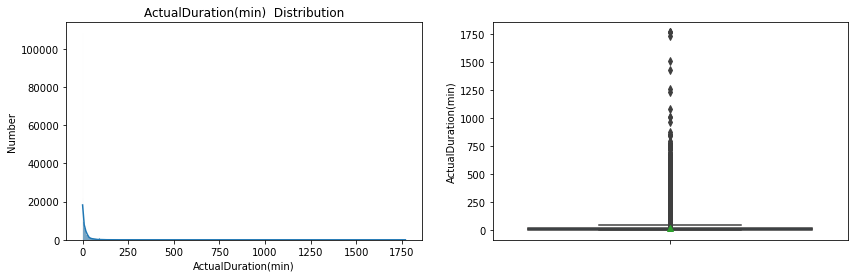

In [146]:
visualize_numerical(listening_detail_df,"ActualDuration(min)")

In [411]:
# bk_listening_detail_df = listening_detail_df.copy()

In [412]:
## Drop những lượt nghe có duration ngắn hơn 3'
listening_detail_df = listening_detail_df[listening_detail_df["ActualDuration(min)"]>=3]
listening_detail_df.shape[0]

399233

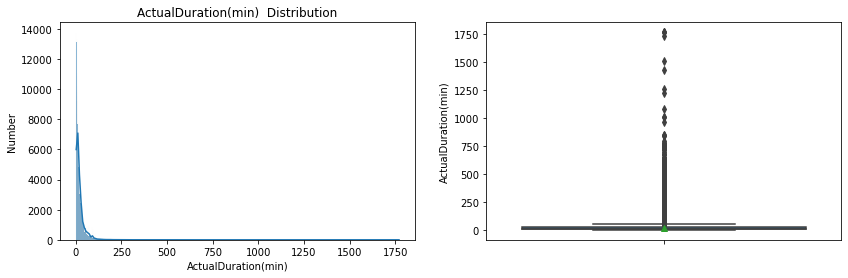

In [108]:
visualize_numerical(listening_detail_df,"ActualDuration(min)")

##### 2. Outliers Frequency:
1. Frequency thấp: Drop những playlist có lượt nghe thấp
<!-- 2. Frequency cao: đưa về mean() -->

In [413]:
### summary theo Playlist

playlist_summary_df = listening_detail_df.groupby(["PlaylistID",'Playlist Name', 'Category', 'SubCategory','PlaylistDuration(min)']).agg({"ListeningDate":["count"]}).reset_index()
playlist_summary_df.columns=['PlaylistID','Playlist Name', 'Category', 'SubCategory','PlaylistDuration(min)','listen_cnt']
playlist_summary_df.shape[0]

1156

In [414]:
### Tính Frequency cho các playlist:
total_listen_cnt = listening_detail_df.shape[0]
playlist_summary_df['Frequency'] = round(playlist_summary_df.listen_cnt/total_listen_cnt,6)
playlist_summary_df[["listen_cnt",'Frequency']].describe()

,listen_cnt,Frequency
count,1156.000000,1156.000000
mean,345.357266,0.000865
std,1229.571407,0.003080
min,1.000000,0.000003
25%,52.750000,0.000132
50%,129.000000,0.000323
75%,300.000000,0.000751
max,24835.000000,0.062207


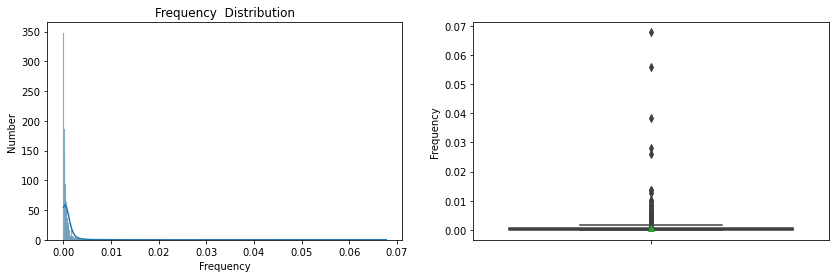

In [258]:
visualize_numerical(playlist_summary_df,"Frequency")

In [415]:
# Drop q_40: những playlist quá ít xuất hiện
q_25 = playlist_summary_df["Frequency"].quantile(0.25)
playlist_summary_df=playlist_summary_df[playlist_summary_df.Frequency>=q_25]
playlist_summary_df[["listen_cnt",'Frequency']].describe()

,listen_cnt,Frequency
count,867.000000,867.000000
mean,453.509804,0.001136
std,1403.370888,0.003515
min,53.000000,0.000133
25%,105.000000,0.000263
50%,192.000000,0.000481
75%,381.500000,0.000955
max,24835.000000,0.062207


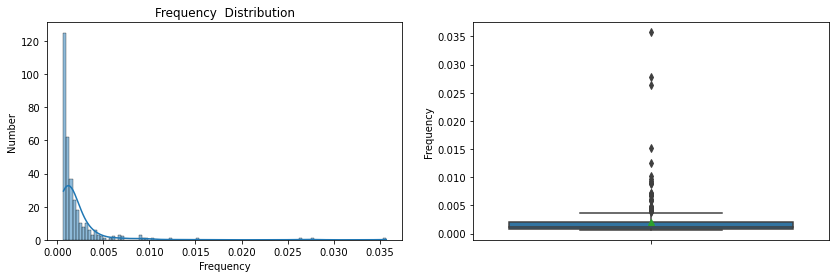

In [263]:
visualize_numerical(playlist_summary_df,"Frequency")

2. Drop những mega hit playlist 

In [416]:
### Bỏ các mega hit
q_95 = playlist_summary_df["Frequency"].quantile(0.998)
playlist_summary_df[playlist_summary_df["Frequency"]>q_95]
# playlist_summary_df.loc[playlist_summary_df["Frequency"].idxmax()]#== 0.062207]


,PlaylistID,Playlist Name,Category,SubCategory,PlaylistDuration(min),listen_cnt,Frequency
589,4612,Muôn Kiếp Nhân Sinh - Tập 1,Sách nói,Tâm linh,616.8,24835,0.062207
695,4735,Đắc Nhân Tâm,Sách nói,Thành công,367.3,21601,0.054106


In [417]:
playlist_summary_df = playlist_summary_df[playlist_summary_df["Frequency"]<q_95]

In [418]:
### Lấy lại listening_detail_df sau khi đã xử lý outliers
listening_detail_df = listening_detail_df[listening_detail_df['PlaylistID'].isin(playlist_summary_df.PlaylistID)]
listening_detail_df.shape[0]

346757

In [419]:
playlist_summary_df.shape[0]

865

### Lấy danh sách các playlists theo transaction

1. Một transaction: danh sách playlits mà users nghe trong vòng 30 ngày
2. playlist_basket: chứa các playlist theo transaction 30 ngày

#### 1. Tính danh sách nghe mỗi 30 ngày của các users
1. Các playlists nằm trong playlist_basket
2. Chỉ lấy những playlist có tổng thời lượng nghe/tổng trong 1thangs Audio >= 1/10

In [421]:
def get_playlists_in_timewindow(user_id,timewindow = 30 ):
    '''
        Return list of playlists that user listens successively in every period of 30 days
    '''
    user_basket = []
    
    df = listening_detail_df[listening_detail_df["UserID"]==user]
    t_min = df['ListeningDate'].min()
    t_max = df['ListeningDate'].max()

    ### tính số transactions có thể có của mỗi users nếu chia ra 15 ngày là 1 transaction
    distance = (t_max - t_min).days
    div_delta = int(distance/timewindow)
    mod_delta = distance%timewindow
    div_delta,mod_delta
    trans_cnt = (div_delta+1) if mod_delta > 0 else div_delta

    ### Xác định các mốc thời gian tương ứng
    freq = str(timewindow)+'D'
    date_points = pd.date_range(start =t_min.date(),periods = trans_cnt+1,freq =freq)
    
    ### Tính playlists của các transactions ứng với các date_point ở trên <= <
    for i in range(trans_cnt):
        
        playlist_df = df[df.ListeningDate.between(date_points[i], date_points[i+1])].groupby(["Playlist Name","PlaylistDuration(min)"]).agg(
        {"ActualDuration(min)":"sum"}).reset_index()
        playlist_df.columns = ["Playlist Name","PlaylistDuration(min)","TotalDuration"]
        
        #chỉ lấy những cuốn trong tháng đó đã nghe hon 1/10
        playlist_df["%"] = playlist_df["TotalDuration"]/playlist_df["PlaylistDuration(min)"]
        playlists = playlist_df[playlist_df["%"]>= 0.2]["Playlist Name"].tolist()

#        playlists = playlist_df["PlaylistID"].tolist()
        
        if len(playlists)>0:
            user_basket.append(playlists)
    
    return(user_basket)

In [422]:
listening_detail_df.shape[0],len(listening_detail_df['UserID'].unique().tolist())

(346757, 12039)

In [423]:
### Playlist basket cho cả hệ thống
playlist_basket = []
users = listening_detail_df['UserID'].unique().tolist()
for user in users:
    user_basket = get_playlists_in_timewindow(user)
    playlist_basket += user_basket
    
len(playlist_basket)

29261

##### Lấy playlists >= 2 items

In [424]:
playlist_basket_OK = [lst for lst in playlist_basket if len(lst)>1]
len(playlist_basket_OK)

11195

In [425]:
# playlist_basket_df = pd.DataFrame(data = np.array(playlist_basket_OK))
# playlist_basket_df.columns = ['playlists']
# playlist_basket_df.to_csv("data/export/playlist_basket_OK.csv", index = False)

<ipython-input-425-dcc5f1a31576>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  playlist_basket_df = pd.DataFrame(data = np.array(playlist_basket_OK))


## Basket Analysis on listening detail

In [426]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

In [427]:
data = playlist_basket_OK

In [429]:
## 2. Importing packages and data preprocessing (about mlxtend)
encode_=TransactionEncoder()
encode_arr=encode_.fit_transform(data)

In [430]:
## 3. Converting to dataframe.
encode_df=pd.DataFrame(encode_arr, columns=encode_.columns_)
#encode_df

In [451]:
## 4. Calculating support.
frequent_items=apriori(encode_df,min_support=0.001, use_colnames=True)
len(frequent_items)

1746

In [452]:
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(10 Quy luật cuộc sống),(Nghìn Lẻ Một Đêm - 1001 đêm),0.024207,0.054757,0.001876,0.077491,1.415186,0.000550,1.024644
1,(Nghìn Lẻ Một Đêm - 1001 đêm),(10 Quy luật cuộc sống),0.054757,0.024207,0.001876,0.034258,1.415186,0.000550,1.010407
2,(Thái độ quyết định thành công),(10 Quy luật cuộc sống),0.131041,0.024207,0.007593,0.057941,2.393556,0.004421,1.035809
3,(10 Quy luật cuộc sống),(Thái độ quyết định thành công),0.024207,0.131041,0.007593,0.313653,2.393556,0.004421,1.266064
4,(10 Quy luật cuộc sống),(Tại sao phải chần chừ?),0.024207,0.007503,0.001072,0.044280,5.901423,0.000890,1.038481


In [453]:
rules.shape[0]

3386

In [462]:
basket =rules[rules['antecedents'].apply(lambda x: len(x) ==1)&
(rules['lift']>3)&(rules['confidence']>=0.3)].sort_values(['lift'],ascending=False)

In [463]:
basket.shape[0]

100

In [473]:
basket[["antecedents","consequents"]].tail(4)

,antecedents,consequents
377,(Bí Quyết Trở Thành Người Xuất Sắc),(Thái độ quyết định thành công)
1439,(Tỏa Sáng Ở Trường Đại Học),(Thái độ quyết định thành công)
11,(10 Điều Tạo Nên Số Phận),(Thái độ quyết định thành công)
1215,(Nghệ thuật sống tự tin),(Thái độ quyết định thành công)


In [474]:
basket[["antecedents","consequents"]].to_csv('data/basket_output.csv',index =False )

#### Print rules

In [396]:
# !pip install apyori

In [466]:
from apyori import apriori
# Training Apriori algorithm on the dataset
rule_list = apriori(playlist_basket_OK, min_support = 0.001, min_confidence = 0.3, min_lift = 3, min_length = 2)

In [467]:
# Visualizing the list of rules
results = list(rule_list)
for i in results:
    print('\n')
    print(i)
    print('**********') 



RelationRecord(items=frozenset({'Thái độ quyết định thành công', '10 Điều Tạo Nên Số Phận'}), support=0.001429209468512729, ordered_statistics=[OrderedStatistic(items_base=frozenset({'10 Điều Tạo Nên Số Phận'}), items_add=frozenset({'Thái độ quyết định thành công'}), confidence=0.4324324324324324, lift=3.299987103668085)])
**********


RelationRecord(items=frozenset({'Ba Chú Lợn', 'Chú Rô Con Không Vâng Lời Mẹ'}), support=0.002590442161679321, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Chú Rô Con Không Vâng Lời Mẹ'}), items_add=frozenset({'Ba Chú Lợn'}), confidence=0.30208333333333337, lift=23.484881365740744)])
**********


RelationRecord(items=frozenset({'Ba Chú Lợn', 'Chú Vịt Xám'}), support=0.0018758374274229566, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Chú Vịt Xám'}), items_add=frozenset({'Ba Chú Lợn'}), confidence=0.3559322033898305, lift=27.671257062146893)])
**********


RelationRecord(items=frozenset({'Chú Thỏ Tinh Khôn', 'Bác Gấu Đen Và H

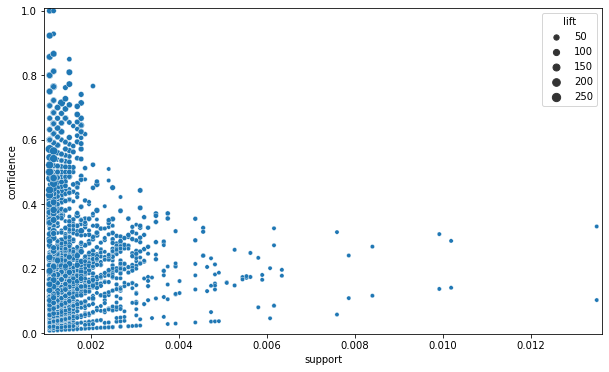

In [471]:
## 7. Scatter plot
## Scatter plots help us to evaluate general tendencies of rules between antecedents and consequents

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt 

# Generate scatterplot using support and confidence
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.margins(0.01,0.01)
plt.show()